In [1]:
import re
import numpy as np
import pandas as pd
import gensim
import nltk
from gensim.models import Word2Vec,FastText
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from skntk import NeuralTangentKernel as NTK
from sklearn.svm import SVC

In [2]:
data=pd.read_csv(r'D:\CODING\Python\NLP\END_SEM\IMDB Dataset.csv')

In [3]:
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

data['review'] = data['review'].apply(preprocess_text)

data['label'] = data['sentiment'].map({'positive': 1, 'negative': 0})


In [5]:
data

,review,sentiment,label
0,"[one, reviewers, mentioned, watching, oz, epis...",positive,1
1,"[wonderful, little, production, br, br, filmin...",positive,1
2,"[thought, wonderful, way, spend, time, hot, su...",positive,1
3,"[basically, theres, family, little, boy, jake,...",negative,0
4,"[petter, matteis, love, time, money, visually,...",positive,1
...,...,...,...
49995,"[thought, movie, right, good, job, wasnt, crea...",positive,1
49996,"[bad, plot, bad, dialogue, bad, acting, idioti...",negative,0
49997,"[catholic, taught, parochial, elementary, scho...",negative,0
49998,"[im, going, disagree, previous, comment, side,...",negative,0


In [6]:
def load_glove(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        word_embeddings = {}
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_embeddings[word] = vector
    return word_embeddings

def generate_embedding_matrix(word_vector, embedding_model, embedding_type, max_length=200):
    if embedding_type == 'glove':
        embedding_dim = len(next(iter(embedding_model.values())))
        embedding_matrix = np.zeros((max_length, embedding_dim))
        for i, word in enumerate(word_vector):
            if word in embedding_model:
                embedding_matrix[i] = embedding_model[word]
            if i >= max_length - 1:
                break
    else:
        word_embeddings = []
        for word in word_vector:
            if word in embedding_model.wv:
                word_embedding = embedding_model.wv[word]
                word_embeddings.append(word_embedding)
        embedding_matrix = np.array(word_embeddings)
        if len(embedding_matrix) < max_length:
            embedding_matrix = np.pad(embedding_matrix, ((0, max_length - len(embedding_matrix)), (0, 0)), mode='constant')
        else:
            embedding_matrix = embedding_matrix[:max_length, :]
    return np.sum(embedding_matrix, axis=0)

def train_word2vec(corpus, vector_size=100, window=10, min_count=1, workers=4, sg=1):
    return Word2Vec(sentences=corpus, vector_size=vector_size, window=window, min_count=min_count, workers=workers, sg=sg)

def train_fasttext(corpus, vector_size=100, window=10, min_count=1, workers=4, sg=1):
    return FastText(sentences=corpus, vector_size=vector_size, window=window, min_count=min_count, workers=workers, sg=sg)

def choose_embedding_model(corpus, model_type, glove_file):
    if model_type == 'word2vec':
        model = train_word2vec(corpus)
    elif model_type == 'fasttext':
        model = train_fasttext(corpus)
    elif model_type == 'glove' and glove_file is not None:
        model = load_glove(glove_file)
    else:
        raise ValueError("Invalid model type or missing GloVe file.")
    return model


In [7]:
tokenized_corpus=data['review'].to_list()

In [8]:
embedding_type = 'fasttext' 
embedding_model = choose_embedding_model(tokenized_corpus, model_type=embedding_type, glove_file=r'D:\CODING\Python\NLP\END_SEM\glove\eng\glove.6B.100d.txt')
data['embedding_matrix'] = data['review'].apply(lambda x: generate_embedding_matrix(x, embedding_model, embedding_type))
X = np.array(data['embedding_matrix'].tolist())
y=data['label'] 

In [9]:
from skntk import NeuralTangentKernel as NTK
from sklearn.svm import SVC

In [10]:
ntk=NTK(3)
svm_classifier = SVC(kernel=ntk)

In [11]:
num_points = 50000
num_iterations = 50
subset_size = 10000

In [12]:
all_reports = []
all_conf_matrices = []

for _ in range(num_iterations):
    sub_indices = np.random.choice(num_points, subset_size, replace=False)
    X_sample = X[sub_indices]
    y_sample = y[sub_indices]
    
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

    svm_classifier.fit(X_train, y_train)

    y_pred = svm_classifier.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    all_reports.append(report)
    all_conf_matrices.append(conf_matrix)
    

In [13]:
def average_classification_report(reports):
    avg_report = {}
    for metric in reports[0].keys():
        if isinstance(reports[0][metric], dict):
            avg_report[metric] = {cls: np.mean([report[metric][cls] for report in reports]) for cls in reports[0][metric].keys()}
        else:
            avg_report[metric] = np.mean([report[metric] for report in reports])
    return avg_report



In [123]:
avg_report = average_classification_report(all_reports)
print("Average Classification Report:")
print(avg_report)

Average Classification Report:
{'0': {'precision': 0.8552620897430994, 'recall': 0.8479461175233548, 'f1-score': 0.8514970232747352, 'support': 996.54}, '1': {'precision': 0.8502137488748296, 'recall': 0.8575619213670046, 'f1-score': 0.8537872759512267, 'support': 1003.46}, 'accuracy': 0.85276, 'macro avg': {'precision': 0.8527379193089645, 'recall': 0.8527540194451798, 'f1-score': 0.8526421496129809, 'support': 2000.0}, 'weighted avg': {'precision': 0.8529679231208134, 'recall': 0.85276, 'f1-score': 0.8527602967037771, 'support': 2000.0}}


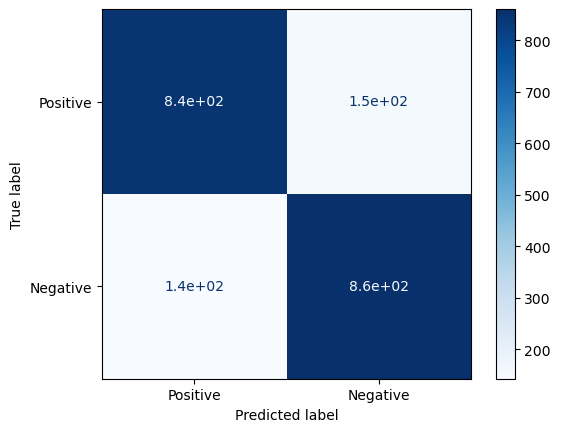

In [124]:
avg_conf_matrix = np.mean(all_conf_matrices, axis=0)

# Display the aggregated confusion matrix
disp = ConfusionMatrixDisplay(avg_conf_matrix, display_labels=['Positive', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

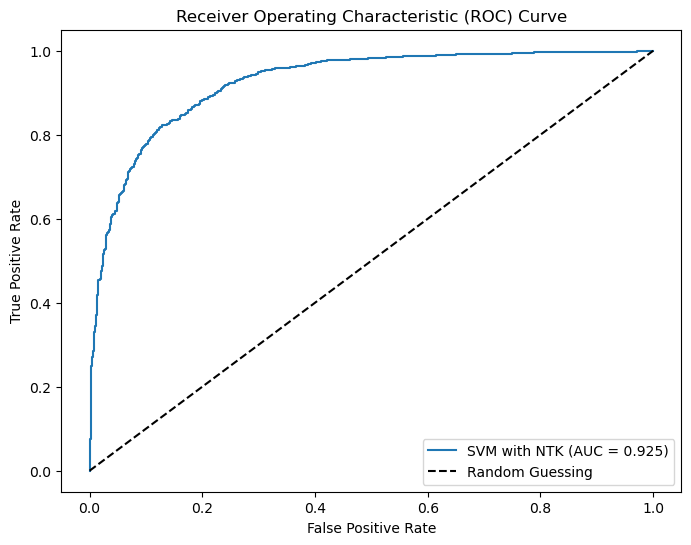

In [125]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# SVM
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_classifier.decision_function(X_test))
svm_auc = auc(svm_fpr, svm_tpr)
ax.plot(svm_fpr, svm_tpr, label='SVM with NTK (AUC = {:.3f})'.format(svm_auc))


# Random guessing line
ax.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

# Axis labels and title
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')

# Legend
ax.legend(loc='best')

# Show the plot
plt.show()

------

For NTK depth 1

In [ ]:
data=pd.read_csv(r'D:\CODING\Python\NLP\END_SEM\IMDB Dataset.csv')

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

data['review'] = data['review'].apply(preprocess_text)

data['label'] = data['sentiment'].map({'positive': 1, 'negative': 0})


In [ ]:
def load_glove(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        word_embeddings = {}
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_embeddings[word] = vector
    return word_embeddings

def generate_embedding_matrix(word_vector, embedding_model, embedding_type, max_length=200):
    if embedding_type == 'glove':
        embedding_dim = len(next(iter(embedding_model.values())))
        embedding_matrix = np.zeros((max_length, embedding_dim))
        for i, word in enumerate(word_vector):
            if word in embedding_model:
                embedding_matrix[i] = embedding_model[word]
            if i >= max_length - 1:
                break
    else:
        word_embeddings = []
        for word in word_vector:
            if word in embedding_model.wv:
                word_embedding = embedding_model.wv[word]
                word_embeddings.append(word_embedding)
        embedding_matrix = np.array(word_embeddings)
        if len(embedding_matrix) < max_length:
            embedding_matrix = np.pad(embedding_matrix, ((0, max_length - len(embedding_matrix)), (0, 0)), mode='constant')
        else:
            embedding_matrix = embedding_matrix[:max_length, :]
    return np.sum(embedding_matrix, axis=0)

def train_word2vec(corpus, vector_size=100, window=10, min_count=1, workers=4, sg=1):
    return Word2Vec(sentences=corpus, vector_size=vector_size, window=window, min_count=min_count, workers=workers, sg=sg)

def train_fasttext(corpus, vector_size=100, window=10, min_count=1, workers=4, sg=1):
    return FastText(sentences=corpus, vector_size=vector_size, window=window, min_count=min_count, workers=workers, sg=sg)

def choose_embedding_model(corpus, model_type, glove_file):
    if model_type == 'word2vec':
        model = train_word2vec(corpus)
    elif model_type == 'fasttext':
        model = train_fasttext(corpus)
    elif model_type == 'glove' and glove_file is not None:
        model = load_glove(glove_file)
    else:
        raise ValueError("Invalid model type or missing GloVe file.")
    return model


In [ ]:
tokenized_corpus=data['review'].to_list()

In [ ]:
embedding_type = 'word2vec' 
embedding_model = choose_embedding_model(tokenized_corpus, model_type=embedding_type, glove_file=r'D:\CODING\Python\NLP\END_SEM\glove\eng\glove.6B.100d.txt')
data['embedding_matrix'] = data['review'].apply(lambda x: generate_embedding_matrix(x, embedding_model, embedding_type))
X = np.array(data['embedding_matrix'].tolist())
y=data['label'] 

In [ ]:
from skntk import NeuralTangentKernel as NTK
from sklearn.svm import SVC

In [ ]:
ntk=NTK(3)
svm_classifier = SVC(kernel=ntk)

In [ ]:
num_points = 50000
num_iterations = 50
subset_size = 10000

In [ ]:
all_reports = []
all_conf_matrices = []

for _ in range(num_iterations):
    sub_indices = np.random.choice(num_points, subset_size, replace=False)
    X_sample = X[sub_indices]
    y_sample = y[sub_indices]
    
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

    svm_classifier.fit(X_train, y_train)

    y_pred = svm_classifier.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    all_reports.append(report)
    all_conf_matrices.append(conf_matrix)
    

In [ ]:
def average_classification_report(reports):
    avg_report = {}
    for metric in reports[0].keys():
        if isinstance(reports[0][metric], dict):
            avg_report[metric] = {cls: np.mean([report[metric][cls] for report in reports]) for cls in reports[0][metric].keys()}
        else:
            avg_report[metric] = np.mean([report[metric] for report in reports])
    return avg_report



In [ ]:
avg_report = average_classification_report(all_reports)
print("Average Classification Report:")
print(avg_report)

In [ ]:
avg_conf_matrix = np.mean(all_conf_matrices, axis=0)

# Display the aggregated confusion matrix
disp = ConfusionMatrixDisplay(avg_conf_matrix, display_labels=['Positive', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# SVM
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_classifier.decision_function(X_test))
svm_auc = auc(svm_fpr, svm_tpr)
ax.plot(svm_fpr, svm_tpr, label='SVM with NTK (AUC = {:.3f})'.format(svm_auc))


# Random guessing line
ax.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

# Axis labels and title
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')

# Legend
ax.legend(loc='best')

# Show the plot
plt.show()

----

For NTK depth 5

In [ ]:
data=pd.read_csv(r'D:\CODING\Python\NLP\END_SEM\IMDB Dataset.csv')

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

data['review'] = data['review'].apply(preprocess_text)

data['label'] = data['sentiment'].map({'positive': 1, 'negative': 0})


In [ ]:
def load_glove(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        word_embeddings = {}
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_embeddings[word] = vector
    return word_embeddings

def generate_embedding_matrix(word_vector, embedding_model, embedding_type, max_length=200):
    if embedding_type == 'glove':
        embedding_dim = len(next(iter(embedding_model.values())))
        embedding_matrix = np.zeros((max_length, embedding_dim))
        for i, word in enumerate(word_vector):
            if word in embedding_model:
                embedding_matrix[i] = embedding_model[word]
            if i >= max_length - 1:
                break
    else:
        word_embeddings = []
        for word in word_vector:
            if word in embedding_model.wv:
                word_embedding = embedding_model.wv[word]
                word_embeddings.append(word_embedding)
        embedding_matrix = np.array(word_embeddings)
        if len(embedding_matrix) < max_length:
            embedding_matrix = np.pad(embedding_matrix, ((0, max_length - len(embedding_matrix)), (0, 0)), mode='constant')
        else:
            embedding_matrix = embedding_matrix[:max_length, :]
    return np.sum(embedding_matrix, axis=0)

def train_word2vec(corpus, vector_size=100, window=10, min_count=1, workers=4, sg=1):
    return Word2Vec(sentences=corpus, vector_size=vector_size, window=window, min_count=min_count, workers=workers, sg=sg)

def train_fasttext(corpus, vector_size=100, window=10, min_count=1, workers=4, sg=1):
    return FastText(sentences=corpus, vector_size=vector_size, window=window, min_count=min_count, workers=workers, sg=sg)

def choose_embedding_model(corpus, model_type, glove_file):
    if model_type == 'word2vec':
        model = train_word2vec(corpus)
    elif model_type == 'fasttext':
        model = train_fasttext(corpus)
    elif model_type == 'glove' and glove_file is not None:
        model = load_glove(glove_file)
    else:
        raise ValueError("Invalid model type or missing GloVe file.")
    return model


In [ ]:
tokenized_corpus=data['review'].to_list()

In [ ]:
embedding_type = 'fasttext' 
embedding_model = choose_embedding_model(tokenized_corpus, model_type=embedding_type, glove_file=r'D:\CODING\Python\NLP\END_SEM\glove\eng\glove.6B.100d.txt')
data['embedding_matrix'] = data['review'].apply(lambda x: generate_embedding_matrix(x, embedding_model, embedding_type))
X = np.array(data['embedding_matrix'].tolist())
y=data['label'] 

In [ ]:
from skntk import NeuralTangentKernel as NTK
from sklearn.svm import SVC

In [ ]:
ntk=NTK(3)
svm_classifier = SVC(kernel=ntk)

In [ ]:
num_points = 50000
num_iterations = 50
subset_size = 10000

In [ ]:
all_reports = []
all_conf_matrices = []

for _ in range(num_iterations):
    sub_indices = np.random.choice(num_points, subset_size, replace=False)
    X_sample = X[sub_indices]
    y_sample = y[sub_indices]
    
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

    svm_classifier.fit(X_train, y_train)

    y_pred = svm_classifier.predict(X_test)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    all_reports.append(report)
    all_conf_matrices.append(conf_matrix)
    

In [ ]:
def average_classification_report(reports):
    avg_report = {}
    for metric in reports[0].keys():
        if isinstance(reports[0][metric], dict):
            avg_report[metric] = {cls: np.mean([report[metric][cls] for report in reports]) for cls in reports[0][metric].keys()}
        else:
            avg_report[metric] = np.mean([report[metric] for report in reports])
    return avg_report



In [ ]:
avg_report = average_classification_report(all_reports)
print("Average Classification Report:")
print(avg_report)

In [ ]:
avg_conf_matrix = np.mean(all_conf_matrices, axis=0)

# Display the aggregated confusion matrix
disp = ConfusionMatrixDisplay(avg_conf_matrix, display_labels=['Positive', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# SVM
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_classifier.decision_function(X_test))
svm_auc = auc(svm_fpr, svm_tpr)
ax.plot(svm_fpr, svm_tpr, label='SVM with NTK (AUC = {:.3f})'.format(svm_auc))


# Random guessing line
ax.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

# Axis labels and title
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')

# Legend
ax.legend(loc='best')

# Show the plot
plt.show()

---------------